# Pybot

In [1]:
import string
import time
import numpy as np
import bot_utils
from collections import defaultdict
from IPython.display import SVG
# Keras imports
import tensorflow as tf
import tensorflow.keras.preprocessing.text as tftext
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, Concatenate
from tensorflow.keras.utils import model_to_dot
from attention import AttentionLayer
# Gensim and Spelling
import gensim.downloader as api
glove_vectors = api.load("glove-wiki-gigaword-100")
from spellchecker import SpellChecker
import concurrent.futures
# Telegram
import logging
from threading import Timer
from telegram import ReplyKeyboardMarkup, ReplyKeyboardRemove, Update, ChatAction
from telegram.ext import (
    Updater,
    CommandHandler,
    MessageHandler,
    Filters,
    ConversationHandler,
    CallbackContext,
)

In [2]:
HYPER_PARAMS = {
    'ENABLE_GPU' : True,
    'ENABLE_SPELLING_SUGGESTION' : False,
    'MESSAGE_TYPING_DELAY' : 4.0,  # Seconds to mimic bot typing
    'DATA_BATCH_SIZE' : 128,
    'DATA_BUFFER_SIZE' : 10000, 
    'EMBEDDING_DIMENSION' : 100,  # Dimension of the GloVe embedding vector
    'MAX_SENT_LENGTH' : 11,       # Maximum length of sentences
    'MAX_SAMPLES' : 2000000,     # Maximum samples to consider (useful for laptop memory)  200000
    'MIN_WORD_OCCURENCE' : 30,    # Minimum word count. If condition not met word replaced with <UNK>
    'MODEL_LAYER_DIMS' : 500,
    'MODEL_LEARN_RATE' : 1e-3,
    'MODEL_LEARN_EPOCHS' : 10,
    'MODEL_TRAINING' : True # If False - Model weights are loaded from file
}

In [3]:
if HYPER_PARAMS['ENABLE_GPU']:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

### Importing the data set
https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

movie_lines:
- lineID
- characterID (who uttered this phrase)
- movieID
- character name
- text of the utterance

movie_conversations:
- characterID of the first character involved in the conversation
- characterID of the second character involved in the conversation
- movieID of the movie in which the conversation occurred
- list of the utterances that make the conversation, in chronological 
order: ['lineID1','lineID2',É,'lineIDN']
has to be matched with movie_lines.txt to reconstruct the actual content


In [4]:
lines = open('data/movie_lines.txt', encoding = 'utf-8', errors = 'ignore').read().split('\n')
conversations = open('data/movie_conversations.txt', encoding = 'utf-8', errors = 'ignore').read().split('\n')

### Pre-processing the data
- Perform cleaning
- Extract Q&As
- Tokenize
- Add padding

In [5]:
def clean_text_to_lower(text):
    """Performs cleaning and lowers text"""
    
    text = text.lower()
    # Expand contractions to words, and remove characters
    for word in text.split():
        if word in bot_utils.CONTRACTIONS:
            text = text.replace(word, bot_utils.CONTRACTIONS[word]) 

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text
    
def get_questions_answers(lines, conversations):
    """Builds question and answers from data sets"""
    # Map id to text of the utterance
    id_to_line = {}
    for line in lines:
        line_ = line.split(' +++$+++ ')
        if len(line_) == 5:
            id_to_line[line_[0]] = line_[4]
    
    questions, answers = [], []
    
    for line in conversations:
        # Extract conversation turns
        conversation = line.split(' +++$+++ ')
        if len(conversation) == 4:
            conversation_turns = conversation[3][1:-1].split(', ')
            turns_list = [turn[1:-1] for turn in conversation_turns]   
            # Split to Q & A
            for i_turn in range(len(conversation_turns) - 1):  
                questions.append(clean_text_to_lower(id_to_line[conversation_turns[i_turn][1:-1]]))
                answers.append(clean_text_to_lower(id_to_line[conversation_turns[i_turn + 1][1:-1]]))
                if len(questions) >= HYPER_PARAMS['MAX_SAMPLES']:
                    return questions, answers
    return questions, answers

def tokenize(lines, conversations):
    """Tokenizes sets to sequences of integers, and adds special tokens.
    Also reduces the vocabulary by replacing low frequency words with an unknown token.
    
    Returns:
    tokenizer: tokenizer,  which might be used later to reverse integers to words,
    tokenized_questions: list, questions as sequence of integers
    tokenized_answers: list, answer as sequence of integers
    size_vocab: int, unique number of words in vocabulary.
    special_tokens: dict, mappings for special tokens"""
    
    questions, answers = get_questions_answers(lines, conversations)
    tokenizer = tftext.Tokenizer(oov_token='<UNK>')
    tokenizer.fit_on_texts(questions + answers)
    
    # Make UNK tokens, reindex tokenizer dicts
    sorted_by_word_count = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
    tokenizer.word_index = {}
    tokenizer.index_word = {}
    index = 1
    for word, count in sorted_by_word_count:
        if count >= HYPER_PARAMS['MIN_WORD_OCCURENCE']:
            tokenizer.word_index[word] = index
            tokenizer.index_word[index] = word
            index += 1
    
    # Add special tokens
    special_tokens = {}
    special_tokens['<PAD>'] = 0 
    special_tokens['<UNK>'] = len(tokenizer.word_index)
    special_tokens['<SOS>'] = special_tokens['<UNK>'] + 1
    special_tokens['<EOS>'] = special_tokens['<SOS>'] + 1
    
    for special_token, index_value in special_tokens.items():
        tokenizer.word_index[special_token] = index_value
        tokenizer.index_word[index_value] = special_token
    
    # Tokenize to integer sequences
    tokenized_questions = tokenizer.texts_to_sequences(questions)
    tokenized_answers = tokenizer.texts_to_sequences(answers)
    
    # Size is equal to the last token's index
    size_vocab = special_tokens['<EOS>'] + 1

    # Add sentence position tokens
    tokenized_questions = [[special_tokens['<SOS>']] + tokenized_question + [special_tokens['<EOS>']]
                           for tokenized_question in tokenized_questions]
    
    tokenized_answers   = [[special_tokens['<SOS>']] + tokenized_answer + [special_tokens['<EOS>']]
                           for tokenized_answer in tokenized_answers]
    
    # Add padding at end so we can use a static input size to the model
    tokenized_questions = pad_sequences(tokenized_questions, 
                                        maxlen=HYPER_PARAMS['MAX_SENT_LENGTH'], 
                                        padding='post')
    tokenized_answers   = pad_sequences(tokenized_answers, 
                                        maxlen=HYPER_PARAMS['MAX_SENT_LENGTH'], 
                                        padding='post')
    
    
    return tokenizer, tokenized_questions, tokenized_answers, size_vocab, special_tokens

In [6]:
tokenizer, tokenized_questions, tokenized_answers,\
size_vocab, special_tokens = tokenize(lines, conversations)

In [7]:
size_vocab

6492

**Create tf.data.Dataset** <br>
Allows caching and prefetching to speed up training.

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'encoder_inputs': tokenized_questions[:, 1:], # Skip <SOS> token
        'decoder_inputs': tokenized_answers[:, :-1] # Skip <EOS> token
    },
    {
        'outputs': tokenized_answers[:, 1:]  # Skip <SOS> token
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(HYPER_PARAMS['DATA_BUFFER_SIZE'])
dataset = dataset.batch(HYPER_PARAMS['DATA_BATCH_SIZE'])
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Create contextual embedding from GloVe
Create embedding layer with out context, from a pre-trained Word2Vec Model from Glove:<br>
https://nlp.stanford.edu/projects/glove/

In [9]:
def load_glove_weights(dimension_embedding):
    """ Load GloVe pre-trained model"""
    path='glove/glove.6B.' + str(dimension_embedding) + 'd.txt'
    word_to_vec = {}
    with open(path, encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word_to_vec[values[0]] = np.asarray(values[1:], dtype='float32')
        file.close()
    return word_to_vec

def load_embedding_weights(word_dictionary, size_vocab, dimension_embedding):
    """Loads embedding weights from GloVe based on our context"""
    word_to_vec = load_glove_weights(dimension_embedding)
    embedding_matrix = np.zeros((size_vocab,
                                HYPER_PARAMS['EMBEDDING_DIMENSION']))
    for word, index in word_dictionary.items():
        embedding_vector = word_to_vec.get(word)
        # Word is within GloVe dictionary
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix, word_to_vec

def build_embedding_layer(word_dictionary, size_vocab, dimension_embedding, length_input): 
    """Builds a non-trainable embedding layer from GloVe 
    pre-trained model, based on our context"""
    embedding_matrix, word_to_vec  = load_embedding_weights(word_dictionary, size_vocab, dimension_embedding)
    size_vocab = size_vocab
    embedding_layer = Embedding(size_vocab,
                                dimension_embedding,
                                input_length=length_input,
                                weights=[embedding_matrix],
                                trainable=False)
    return embedding_matrix, word_to_vec, embedding_layer

In [10]:
embedding_matrix, word_to_vec, embedding_layer = build_embedding_layer(tokenizer.word_index, 
                                                                       size_vocab,
                                                                       HYPER_PARAMS['EMBEDDING_DIMENSION'],
                                                                       HYPER_PARAMS['MAX_SENT_LENGTH'])

### Seq2Seq Model

In [11]:
def seq2seq(embedding_layer, length_input, size_vocab, layer_dims):
    """LSTM Seq2Seq model with attention"""
    length_input = length_input - 1
    # 
    # Encoder,
    # Biderectional (RNNSearch) as explained in https://arxiv.org/pdf/1409.0473.pdf 
    #
    encoder_inputs = Input(shape=(length_input, ), name='encoder_inputs')
    encoder_embedding = embedding_layer(encoder_inputs)
    ecoder_lstm = Bidirectional(LSTM(layer_dims,
                                     return_state=True,
                                     return_sequences=True,
                                     dropout=0.05,
                                     recurrent_initializer='glorot_uniform',
                                     name='encoder_lstm'),
                                name='encoder_bidirectional')
    
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = ecoder_lstm(encoder_embedding)
    # For annotating sequences, we concatenate forward hidden state with backward one as explained in top paper
    state_h = Concatenate(name='encoder_hidden_state')([forward_h, backward_h])
    state_c = Concatenate(name='encoder_cell_state')([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    
    # 
    # Decoder,
    # Unidirectional
    #
    decoder_inputs = Input(shape=(length_input, ), name='decoder_inputs')
    decoder_embedding = embedding_layer(decoder_inputs)
    decoder_lstm = LSTM(layer_dims * 2, # to match bidirectional size
                        return_state=True,
                        return_sequences=True,
                        dropout=0.05,
                        recurrent_initializer='glorot_uniform',
                        name='decoder_lstm')
    # Set encoder to use the encoder state as initial states
    decoder_output,_ , _, = decoder_lstm(decoder_embedding,
                                         initial_state=encoder_states)
    
    # Attention
    attention_layer = AttentionLayer(name='attention_layer')
    attention_output, attention_state = attention_layer([encoder_outputs, decoder_output])
    decoder_concat = Concatenate(axis=-1)([decoder_output, attention_output])
    
    # Output layer
    outputs = Dense(size_vocab, name='outputs', activation='softmax')(decoder_concat)
    
    return Model([encoder_inputs, decoder_inputs], outputs), decoder_embedding

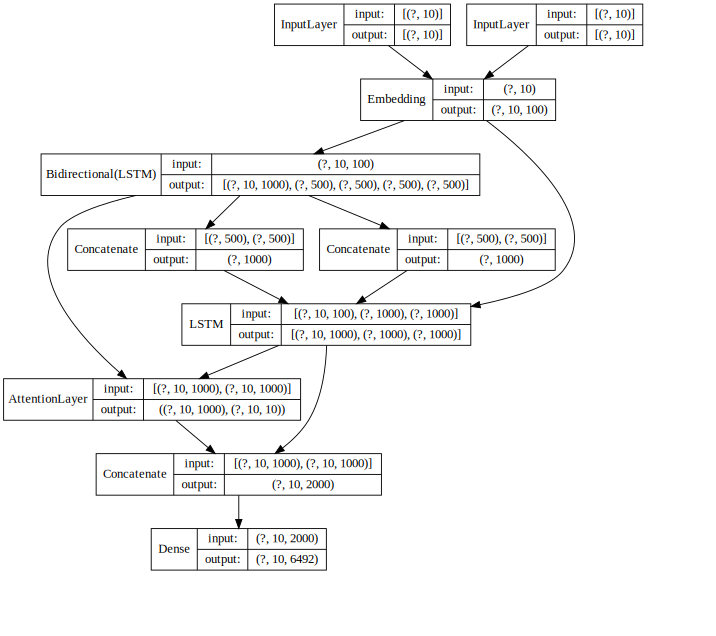

In [12]:
model, decoder_embedding = seq2seq(embedding_layer, 
                                   HYPER_PARAMS['MAX_SENT_LENGTH'], 
                                   size_vocab,
                                   HYPER_PARAMS['MODEL_LAYER_DIMS'])

optimizer = Adam(learning_rate=HYPER_PARAMS['MODEL_LEARN_RATE'])
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=65).create(prog='dot', format='svg'))

### Training
Optionally load weights

In [13]:
if HYPER_PARAMS['MODEL_TRAINING']:
    model.fit(dataset, epochs=HYPER_PARAMS['MODEL_LEARN_EPOCHS'], batch_size=HYPER_PARAMS['DATA_BATCH_SIZE'])
    model.save('backup_{0}.h5'.format(HYPER_PARAMS['MODEL_LEARN_EPOCHS']))
else:
    model.load_weights('backup_{0}.h5'.format(HYPER_PARAMS['MODEL_LEARN_EPOCHS']))

### Predictions processing
- Follow the same tokeninzing approach as before
- For words that are not in our original context, we use the GloVe embedding to find the most similar word within our vocabulary. If it is still a weird word, it will be replaced by an unknown token

In [14]:
def get_known_words(sentence_words, glove_word_dictionary, local_word_dictionary, topn=20):
    """Pre-process the input text, corrects spelling, 
    get similar words from gensim if input word is out of context
    or replace with <UNK> for bad words."""
    result = []
    for word in sentence_words:
        
        # Correct any spelling mistakes
        spell = SpellChecker()
        word = spell.correction(word)
        
        if word in local_word_dictionary:
            result.append(word) 
        else:
            # Determine if top match is within our local context
            found_sim_word = False
            if word in glove_word_dictionary:
                similar_words = glove_vectors.similar_by_word(word, topn=topn)
                for (sim_word, measure) in similar_words:
                    if sim_word in local_word_dictionary.keys():
                        found_sim_word = True
                        result.append(sim_word)
                        break
            # Funny word
            if not found_sim_word:
                result.append('<UNK>')
    return result
            
def pre_process_new_questions(text, tokenizer, glove_vectors, special_tokens):
    """ Process text to words within our context,
    and tokenize."""
    # Pre-process
    text_ = clean_text_to_lower(text)
    split_text = text_.split(' ')
    split_text = get_known_words(split_text, glove_vectors, tokenizer.word_index)
    processed_question = " ".join(split_text)
    # Tokenize to sequence of ints
    # using original tokenizer
    tokenized_question = tokenizer.texts_to_sequences([processed_question])
    tokenized_question = [[special_tokens['<SOS>']] + 
                          tokenized_question[0] + 
                          [special_tokens['<EOS>']]]

    # Padding                                                                     
    tokenized_question = pad_sequences(tokenized_question, 
                                       maxlen=HYPER_PARAMS['MAX_SENT_LENGTH'] - 1, 
                                       padding='post')                                                                       
    return processed_question, tokenized_question[0]

def post_process_new_answers(text_sequence, tokenizer, glove_vectors):
    answer = []
    # Build string from text sequence
    for text_id in text_sequence:
        if text_id != tokenizer.word_index['<EOS>'] and\
           text_id != tokenizer.word_index['<PAD>']:
            word = tokenizer.index_word[text_id]
            if len(answer) == 0:
                word = word.capitalize()
            answer.append(word)
    answer = " ".join(answer)
    return answer

**Example of correction** <br>
Vanish is not within our model's context, but dissapear is

In [15]:
processed_question, _ = pre_process_new_questions('i wouzld like tso vansish', tokenizer, glove_vectors, special_tokens) 
processed_question

'i would like to disappear'

### Predictions

In [16]:
def get_encoder_decoder(model):
    """ Get the encoder and decoder models,
        used to do inference of text sequences"""
    
    # Encoder model
    encoder_model = Model(model.get_layer('encoder_inputs').output,
                          [model.get_layer('encoder_bidirectional').output[0],
                          [model.get_layer('encoder_hidden_state').output, 
                           model.get_layer('encoder_cell_state').output]])
    
    # Decoder model
    decoder_state_input_h = Input(shape=(HYPER_PARAMS['MODEL_LAYER_DIMS'] * 2, ))
    decoder_state_input_c = Input(shape=(HYPER_PARAMS['MODEL_LAYER_DIMS'] * 2, ))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = model.get_layer('decoder_lstm')(decoder_embedding,
                                                                        initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    
    decoder_model = Model([model.get_layer('decoder_inputs').output, 
                           decoder_states_inputs],
                          [decoder_outputs] + decoder_states)

    return encoder_model, decoder_model

def infer_answer_sentence(model, encoder_model, decoder_model, raw_question, tokenizer, glove_vectors, special_tokens):
    
    processed_question, tokenized_question = pre_process_new_questions(raw_question, 
                                                                       tokenizer, 
                                                                       glove_vectors, 
                                                                       special_tokens)
    tokenized_question = tf.expand_dims(tokenized_question, axis=0)
    
    # Encode input sentence
    encoder_outputs, states = encoder_model.predict(tokenized_question)
    
    # Create starting input with only <SOS> token
    decoder_input = tf.expand_dims(special_tokens['<SOS>'], 0)
    
    decoded_answer_sequence = []
    
    while len(decoded_answer_sequence) < HYPER_PARAMS['MAX_SENT_LENGTH']:
        decoder_outputs , decoder_hidden_states , decoder_cell_states = decoder_model.predict([decoder_input] + states)
        # Apply attention to decoder output
        attention_layer = AttentionLayer()
        attention_outputs, attention_states = attention_layer([encoder_outputs, decoder_outputs])
        decoder_concatenated = Concatenate(axis=-1)([decoder_outputs, attention_outputs])
        dense_output = model.get_layer('outputs')(decoder_concatenated)
        
        # Get argmax of output
        sampled_word = np.argmax(dense_output[0, -1, :])
        
        # Finished output sentence
        if sampled_word == special_tokens['<EOS>']:
            break
        
        # Store prediction, and use it as the decoder's new input
        decoded_answer_sequence.append(sampled_word)
        decoder_input = tf.expand_dims(sampled_word, 0)
        
        # Update internal states each timestep
        states = [decoder_hidden_states, decoder_cell_states]
        
    answer = post_process_new_answers(decoded_answer_sequence, tokenizer, glove_vectors)
    
    return answer

In [17]:
encoder_model, decoder_model = get_encoder_decoder(model)

## Interface with Telegram

In [18]:
# Enable logging
logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO
)

updater = Updater("1396342801:AAElqHfd2RGJI-lhdbVevFYSIW4HolMjS7E", use_context=True)
# Get the dispatcher to register handlers
dispatcher = updater.dispatcher
spell = SpellChecker()

In [19]:
WELCOMED_IDS = []
MARKUP_MESSAGES = defaultdict(int)

def welcome_message(chat_id, context):
    context.bot.send_message(chat_id=chat_id, text=
    'Hi there! I am NLTChatBot. \n' +
    'I have studied the transcripts of 617 movies to learn to speak.' +
    ' Ask me anything! ' + u'\U0001F603' )
    WELCOMED_IDS.append(chat_id)
    
def check_grammar(message):
    _message = message.replace("?", "").split(' ')
    processed_message = []
    highlited_grammar = []
    flag = False
    for word in _message:
        corrected_word = spell.correction(word)
        processed_message.append(corrected_word)
        if corrected_word != word:
            # Bold correction
            highlited_grammar.append('<b>'+ word + '</b>')
            flag = True
        else:
            highlited_grammar.append(word)
    return ' '.join(highlited_grammar), ' '.join(processed_message), flag

def handle_message(update, context): 
    # Delete old markup option if user didn't select it
    if MARKUP_MESSAGES[update.effective_chat.id] != 0:
        try:
            context.bot.deleteMessage(chat_id = update.effective_chat.id, 
                                      message_id = MARKUP_MESSAGES[update.effective_chat.id])
        # Chat possibly closed
        except:
            MARKUP_MESSAGES[update.effective_chat.id] = 0
        MARKUP_MESSAGES[update.effective_chat.id] = 0
        
    # New user?
    if update.effective_chat.id not in WELCOMED_IDS:
        welcome_message(update.effective_chat.id, context)
        return
    
    if HYPER_PARAMS['ENABLE_SPELLING_SUGGESTION']:
        # Check grammar
        highlited_grammar, processed_message, flag = check_grammar(update.message.text) 
        if flag:
            # Spelling suggestions,
            reply_keyboard = [[processed_message]]
            message = update.message.reply_text('I am not sure what you meant with - ' + highlited_grammar,
                                                 reply_markup=ReplyKeyboardMarkup(reply_keyboard, 
                                                 one_time_keyboard=True), 
                                                 parse_mode='HTML')
            MARKUP_MESSAGES[update.effective_chat.id] = message.message_id
            return
    else:
        processed_message = update.message.text
    
    # Reply to user
    answer = infer_answer_sentence(model, 
                                   encoder_model, 
                                   decoder_model, 
                                   processed_message, 
                                   tokenizer, 
                                   glove_vectors, 
                                   special_tokens)
    
    context.bot.send_message(chat_id=update.effective_chat.id, text=answer)

def received_message(update, context):
    """Mimics the typing on keybord,
    before calling the message handling"""
    if HYPER_PARAMS['MESSAGE_TYPING_DELAY'] > 0:
        context.bot.send_chat_action(chat_id=update.effective_chat.id, action=ChatAction.TYPING)
        timed_response = Timer(HYPER_PARAMS['MESSAGE_TYPING_DELAY'], handle_message, [update, context])
        timed_response.start()
    else:
        handle_message(update, context)

In [20]:
message_handler = MessageHandler(Filters.text & (~Filters.command), received_message)
dispatcher.add_handler(message_handler)
updater.start_polling()